This tutorial will go through running a likelihood analysis with CCL. It will compare "data" and "model" angular shear power spectrum, to predict the correct $\Omega_c$ and $\sigma_8$.

In [1]:
import emcee # MCMC package http://dan.iel.fm/emcee/current/
%pylab inline
import seaborn as sns; sns.set_style('darkgrid')  # for nicer plots http://seaborn.pydata.org -- optional
import pyccl as ccl

Populating the interactive namespace from numpy and matplotlib


# The "Data"

Let's create the "data" in the form of $C_\ell$ As a proof of point, we'll make the "data" using CCL. As a proof of concept, this will suffice, but normally you will want to input your real data here.

First, we have to define a redshift distribution:

In [2]:
z = np.linspace(0., 3., 200)
i_lim = 26. # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744

ell = np.arange(2, 2000)

Ngal = 46. * 100.31 * (i_lim - 25.) # Normalisation, galaxies/arcmin^2
pz = 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
dNdz = Ngal * pz # Number density distribution

Now let's set the cosmological parameters for our "data" and create it as an angular shear $C_\ell$

In [3]:
p = ccl.Parameters(Omega_c=0.27, Omega_b=0.045, h=0.67, n_s=0.96,  sigma8=0.83)
cosmo = ccl.Cosmology(p, transfer_function='boltzmann')

tracer1 = ccl.ClTracer(cosmo,tracer_type='lensing',n=[z,dNdz])
tracer2 = ccl.ClTracer(cosmo,tracer_type='lensing',n=dNdz,z=z)
data    = ccl.angular_cl(cosmo, tracer1, tracer2, ell) #C_ell

A simple plot to see how this looks:

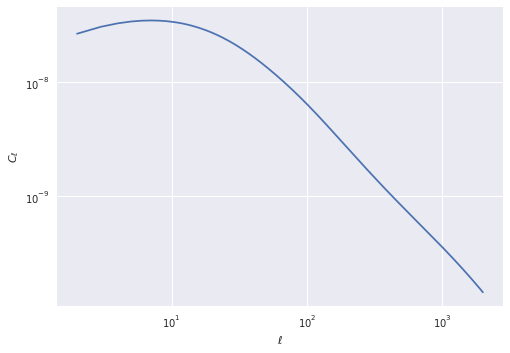

In [4]:
plt.plot(ell,data)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')

Make a covariance matrix. For the purpose of demonstration, we'll simply make a diagonal covariance matrix. Again you will want to input the actual covariance matrix here.

In [5]:
cov = np.diag(data**2)/((4*pi*18000)*(np.pi/180)**2) # C_ell^2/Area of LSST survey
icov = np.linalg.inv(cov)

## Run the MCMC:

Let's define our model that we want to test against our data. We'll use the same redshift distribution as above.

We will define ln(probability) (easier computationally, in case you want to add in a prior and get a posterior distribution). Theta is the set of $\Omega_c$ and $\sigma_8$

For the likelihood analysis, we'll use the MCMC to find the set of parameters that minimises $\chi^2 =(d - t)^T \cdot \Sigma^{-1} \cdot (d-t)$, with $\Sigma$: the covariance matrix $d$: data, and $t$: theory. The likelihood is then $L = e^{- \chi^2 / 2}$


In [6]:
def lnprob(theta):
    for i in range(len(theta)):
        p = ccl.Parameters(Omega_c=theta[0], Omega_b=0.045, h=0.67, n_s=0.96,  sigma8=theta[1])
        cosmo = ccl.Cosmology(p, transfer_function='boltzmann')
        tracer1 = ccl.ClTracer(cosmo,tracer_type='lensing',n=[z,dNdz])
        tracer2 = ccl.ClTracer(cosmo,tracer_type='lensing',n=dNdz,z=z)
        model = ccl.angular_cl(cosmo, tracer1, tracer2, ell)
        diff = data-model
    return -np.dot(diff,np.dot(icov,diff))/2.0

We'll sample a 2-dimensional Gaussian

In [7]:
ndim = 2

Choose an initial set of positions for the walkers as a 2-d gaussian around some reasonable values:

In [8]:
nwalkers = 10
p0 = [np.array([0.27,0.83])*np.ones(ndim)+np.array([0.05,0.1]) * numpy.random.rand() for i in range(nwalkers)] 
p0 = np.array(p0)
p0 = p0 - len(p0)*[[0.025,0.05]]

Initialize the sampler with the chosen specs.

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

Run 50 steps as a burn-in

In [ ]:
pos, prob, state = sampler.run_mcmc(p0, 50)

Reset the chain to remove the burn-in samples

In [ ]:
sampler.reset()

Starting from the final position in the burn-in chain, sample for 100 steps

In [ ]:
_ = sampler.run_mcmc(pos, 100, rstate0=state) # the _ is only there to suppress output.

Print out the mean acceptance fraction. In general, acceptance_fraction has an entry for each  walker so, in this case, it is a 10-dimensional vector.

In [ ]:
print "Mean acceptance fraction:", np.mean(sampler.acceptance_fraction)

Get the samples from the results to plot them later:

In [ ]:
samples = sampler.chain[:, :, :].reshape((-1, ndim))

$95\%$ Confidence interval:

In [ ]:
map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [2.5, 50, 97.5],
                                                axis=0)))

Results as a contour plot $-$ we will be using a seaborn jointplot here, but you might want to check the `corner` python package as an alternative.

In [ ]:
sns.jointplot(samples[:,0],samples[:,1],kind='kde',stat_func=None)